In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm

# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']

# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])



Text(0, 0.5, 'Yield')

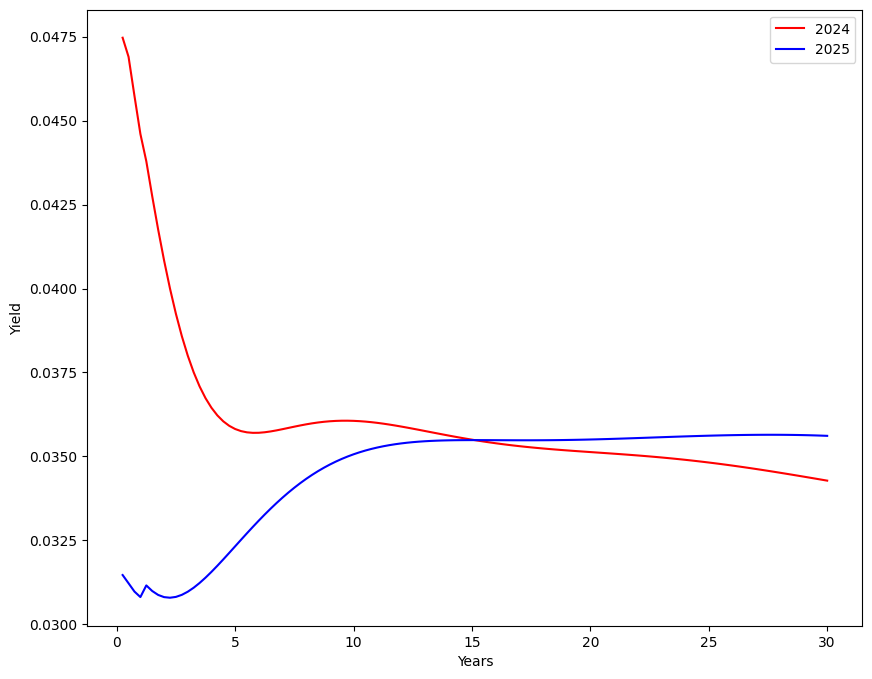

In [2]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')
plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')

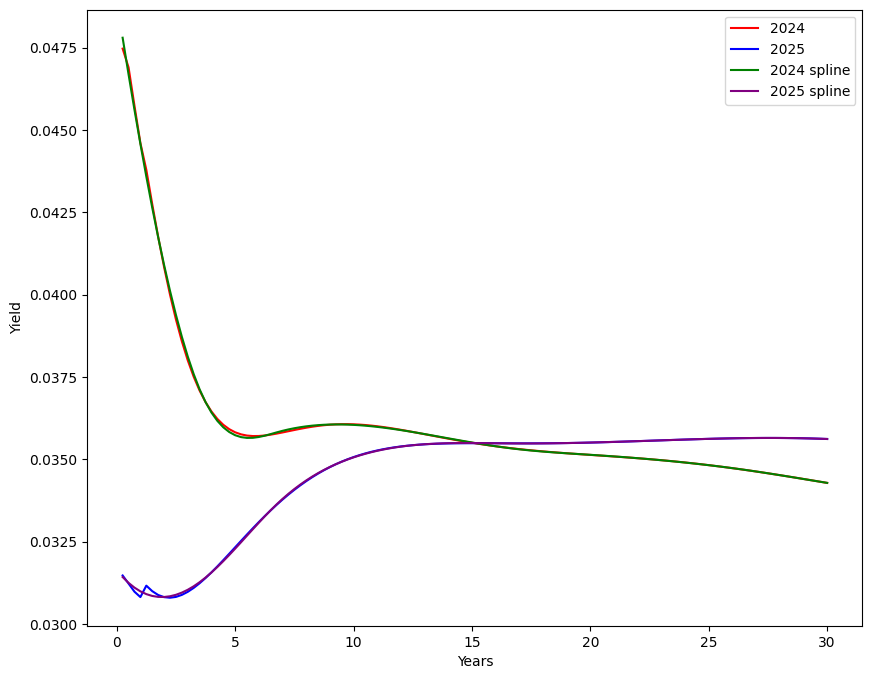

In [3]:
######### make model for splines to inteporlate the yield curve #########

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.show()

In [4]:
# given a date and a list of cash flow dates, find the number of years to the next cash flow date
def years_to_next_date(date, cash_flow_dates):

    days_to_next = [(cash_flow_date - date).days for cash_flow_date in cash_flow_dates if cash_flow_date > date]

    return min(days_to_next)/365

# fuction that given a start date, end date and frequency returns a list of dates that are the cash flow dates
def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates


# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    # generate cashflow dates
    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_next_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the first cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

# a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):

    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

# make a function that combines everything
def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set day to 2024-05
date_2024 = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['2024_value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2024, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

# the total price of all the bonds in the canadian market
bonds['2024_value'].sum()

9739715.52458329

In [5]:
# the total price of all the bonds in the USA market
bonds['raw_reported_price'] = bonds['RPTD_LAST_PR'] * bonds['PRINCIPAL_AMT'] /100
bonds['raw_reported_price'].sum()


9417960.74751

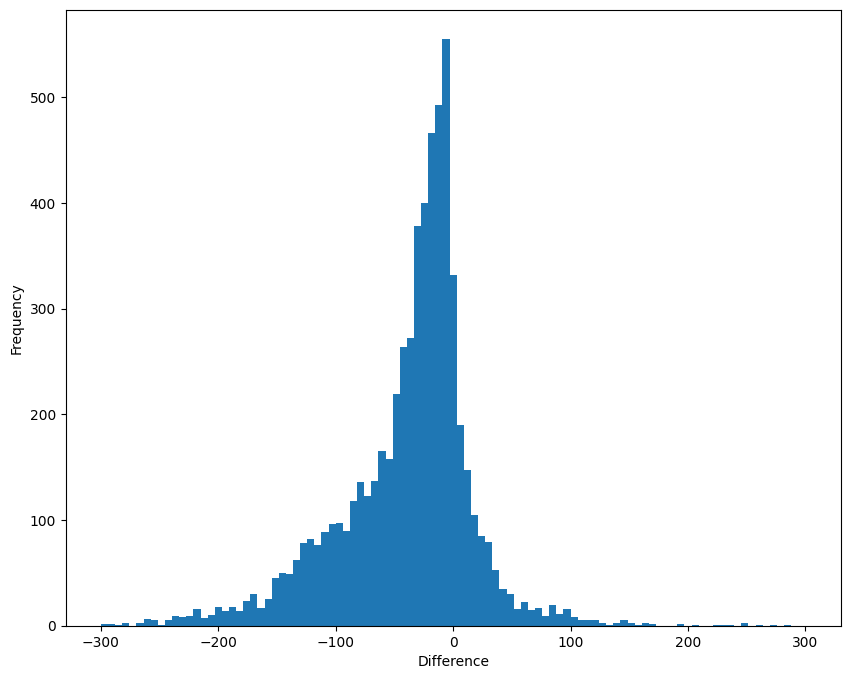

In [6]:
# take the difference between the usa prices and the canadian prices
bonds['difference'] = bonds['raw_reported_price'] - bonds['2024_value']

# histogram the differences only for a certain range
plt.figure(figsize=(10, 8)) 

plt.hist(bonds['difference'], bins=np.linspace(-300, 300, 100))

plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [7]:
# 2025 bond prices

# set day to jan 13, 2025
date_2025 = datetime(2025, 1, 13).date()

# remove the bonds that have already matured
bonds_2025 = bonds[bonds['MATURITY'] > datetime(2025,1,13)].copy()

# apply the bond_value function to the bonds df
bonds_2025['2025_value'] = bonds_2025.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2025, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2025, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

# sum of all teh bond values
bonds_2025['2025_value'].sum()

9506016.551182806

/Library/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


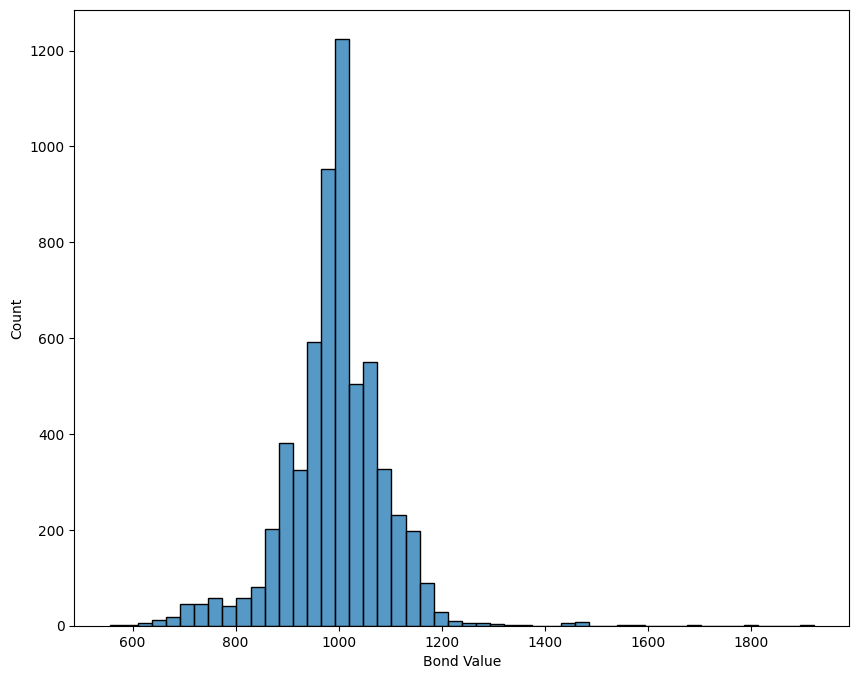

In [8]:
# make a distribution of the bond values for the bonds less than 100 000
plt.figure(figsize=(10, 8))

sns.histplot(bonds_2025[bonds_2025['2025_value'] < 2000]['2025_value'], bins=50)

plt.xlabel('Bond Value')

plt.show()

In [9]:
bonds_2025.head()

,ISSUE_ID,TRD_EXCTN_DT,RPTD_LAST_PR,MATURITY,TREASURY_SPREAD,OFFERING_DATE,PRINCIPAL_AMT,INTEREST_FREQUENCY,COUPON,RATING,SECURITY_LEVEL,2024_value,raw_reported_price,difference,2025_value
0,2560,2024-05-31,114.375,2031-09-15,80.0,1991-09-10,1000,2,8.750,BBB,SEN,1288.882531,1143.75,-145.132531,1299.344489
1,2562,2024-05-31,113.800,2031-11-15,85.0,1991-11-08,1000,2,8.625,BBB,SEN,1268.053609,1138.00,-130.053609,1278.997241
3,2564,2024-05-31,114.080,2043-04-15,100.0,1993-04-06,1000,2,7.875,BBB,SEN,1435.084790,1140.80,-294.284790,1443.434116
4,2566,2024-05-31,100.915,2025-06-15,69.0,1993-06-29,1000,2,7.250,BBB,SEN,1055.062910,1009.15,-45.912910,1020.093768
5,3857,2024-05-31,107.528,2029-10-15,8.0,1989-10-17,1000,2,8.000,BBB,SEN,1220.277010,1075.28,-144.997010,1227.372563


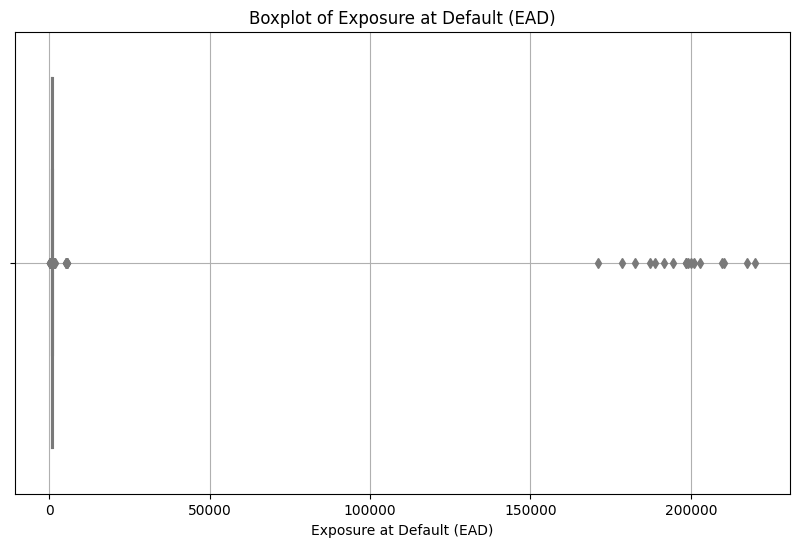

Descriptive Statistics of Exposure at Default (EAD):
count      6045.000000
mean       1489.865195
std       10415.399646
min         224.380000
1%          602.726596
25%         886.860000
50%         960.580000
75%         993.940000
95%        1061.712000
99%        1148.732800
max      219898.000000
Name: EAD, dtype: float64


/Library/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


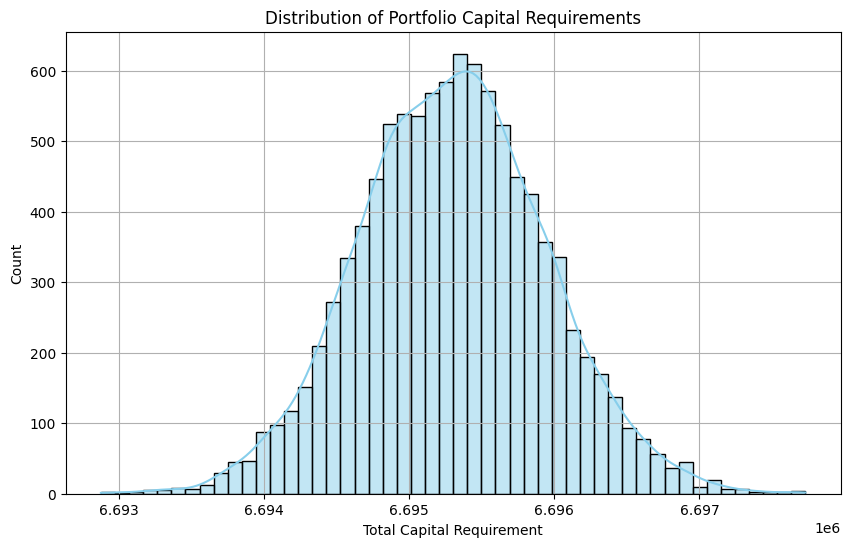

Total Expected Loss: 13,400.19
Mean RWA: 6695300.162747002
Std RWA: 641.9745303245334
95% percentile RWA: 6696369.066431523
99% percentile RWA: 6696838.381091766

=== Descriptive Statistics for Individual Bonds ===
       Mean_Capital_Requirement                                        \
                          count         mean          std         min   
RATING                                                                  
A                        2087.0   811.273051  3953.622342   89.424209   
AA                        317.0   387.854979   323.109256   40.259909   
AAA                        57.0    -0.009768     0.007093   -0.027425   
B                         151.0  1372.915236   645.716323  581.422178   
BB                        414.0  1074.902668   747.914482  507.773725   
BBB                      2946.0  1386.013078  9729.695251  189.204647   
CCC/C                      73.0  1968.621951   602.007560  565.126624   

                                                      

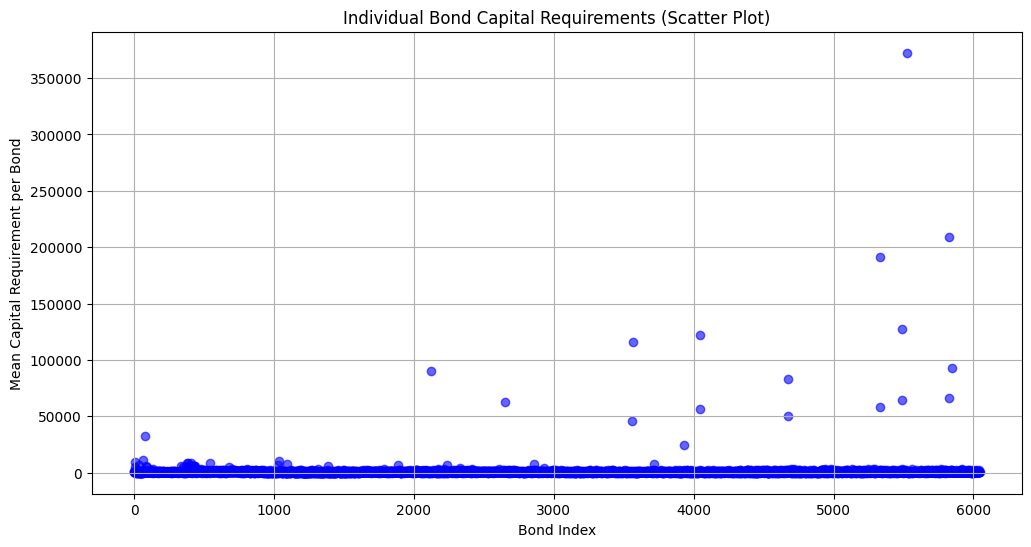

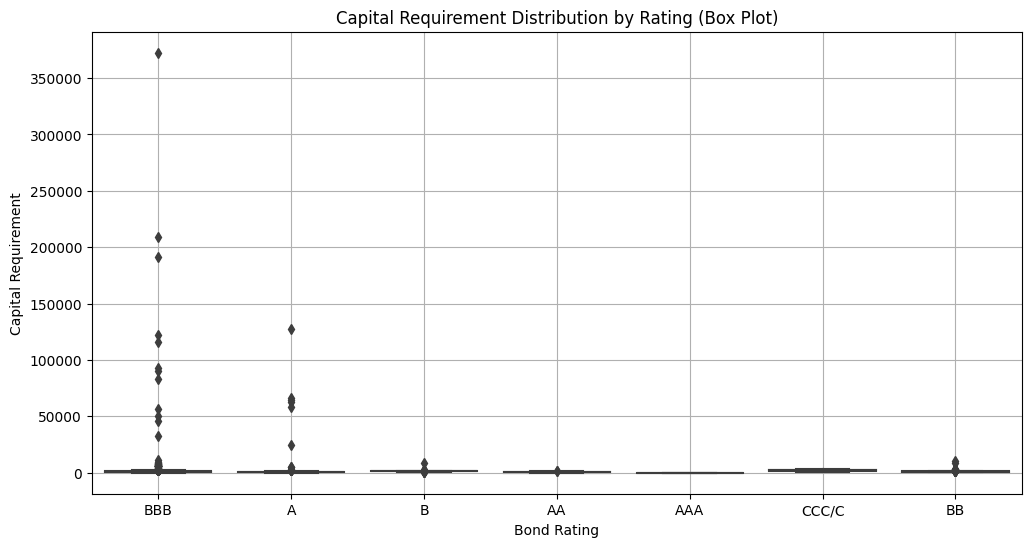

/Library/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


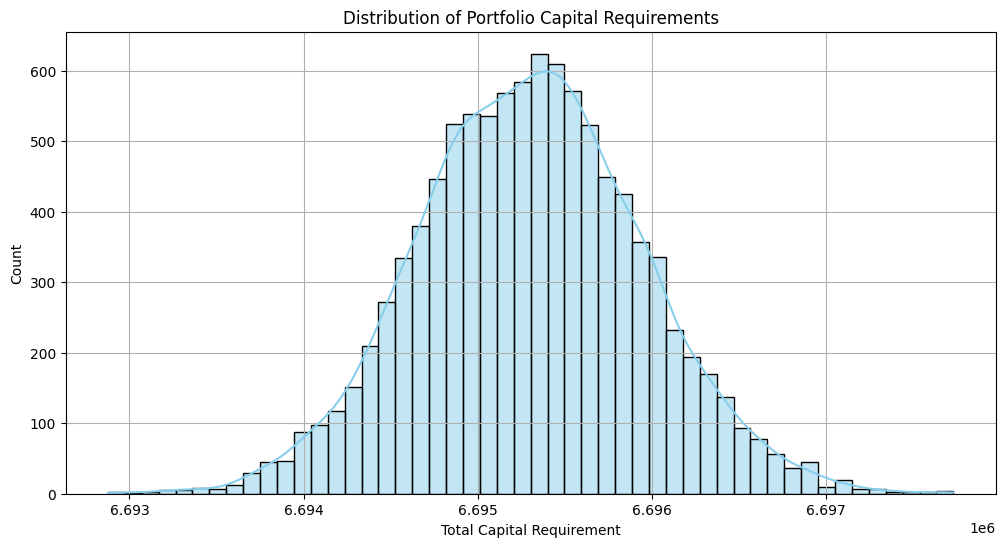

Total Expected Loss: 13,400.19
Mean RWA: 6695300.162747002
Std RWA: 641.9745303245334
95% percentile RWA: 6696369.066431523
99% percentile RWA: 6696838.381091766


In [10]:
# ============================================================
# 【Question 3: Step-by-step Basel III Capital Requirement】
# ============================================================

# Step a: Prepare rating and default probabilities from OSFI
# Under the foundation approach, senior claims on sovereigns, PSEs, banks, securities firms and other financial institutions (including insurance companies and any financial institutions in the corporate asset class) that are not secured by recognized collateral will be assigned a 45% LGD. Senior claims on other corporates that are not secured by recognized collateral will be assigned a 40% LGD. [Basel Framework, CRE 32.6]
df_rating = pd.DataFrame({
    'Rating': ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C'],
    'PD_mean': [1e-9, 0.0002, 0.0005, 0.0014, 0.0057, 0.0298, 0.2598],
    'PD_std': [1e-9, 0.0006, 0.001, 0.0025, 0.0096, 0.0323, 0.1173]
})
bonds_2025.loc[:, 'RATING'] = bonds_2025['RATING'].replace({'CCC':'CCC/C', 'CC':'CCC/C', 'C':'CCC/C'})
bonds_2025 = bonds_2025.merge(df_rating, left_on='RATING', right_on='Rating', how='left')

# Step b: Calculate Exposure at Default (EAD)
# EAD calculation using given face values (principal) and reported prices
bonds_2025['EAD'] = bonds_2025['PRINCIPAL_AMT'] * (bonds_2025['RPTD_LAST_PR'] / 100)

# Visualization of EAD using boxplot for clarity
plt.figure(figsize=(10,6))
sns.boxplot(x=bonds_2025['EAD'], color='lightblue')
plt.xlabel('Exposure at Default (EAD)')
plt.title('Boxplot of Exposure at Default (EAD)')
plt.grid(True)
plt.show()

# Descriptive statistics for clarity
EAD_desc = bonds_2025['EAD'].describe(percentiles=[0.01,0.25,0.5,0.75,0.95,0.99])
print("Descriptive Statistics of Exposure at Default (EAD):")
print(EAD_desc)

# Step c: Monte Carlo simulation of PD using Z-distributed variable
num_simulations = 10000
simulated_pds = np.zeros((len(bonds_2025), num_simulations))
for idx, row in bonds_2025.iterrows():
    z_values = np.random.normal(0, 1, num_simulations)
    pd_mean = max(row['PD_mean'], 1e-9)
    pd_std = row['PD_std']
    simulated_pds[idx] = np.exp(np.log(pd_mean) + pd_std * z_values)

# Step c (continued): Basel III RWA calculation with maturity adjustment
# LGD values based on SECURITY_LEVEL
def calculate_lgd(row):
    if row['SECURITY_LEVEL'] in ['SEN', 'SS']:
        return 0.45  # LGD for SEN and SS
    else:
        return 0.75  # LGD for all others (JUN, SENS, SUB)

# Applying the function to calculate LGD for each bond
bonds_2025['LGD'] = bonds_2025.apply(calculate_lgd, axis=1)

import pandas as pd
from datetime import datetime

# Set the dates
date_2024 = datetime(2024, 5, 31).date()
date_2025 = datetime(2025, 1, 13).date()

# Convert MATURITY column to datetime
bonds_2025['MATURITY'] = pd.to_datetime(bonds_2025['MATURITY'], errors='coerce')

# Convert the date_2024 to pandas Timestamp to ensure compatibility with MATURITY
date_2024 = pd.to_datetime(date_2024)

# Calculate the difference in years
bonds_2025['Maturity_years'] = (bonds_2025['MATURITY'] - date_2024).dt.days / 365

def calculate_RWA_full(PD, LGD, EAD, M):
    PD = np.clip(PD, 1e-9, 1-1e-9)
    R = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50)) + 0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
    b = (0.11852 - 0.05478 * np.log(PD))**2
    adjustment = (1 + (M - 2.5)*b)/(1 - 1.5*b)
    K = (LGD * norm.cdf((norm.ppf(PD)+np.sqrt(R)*norm.ppf(0.999))/np.sqrt(1-R))-PD*LGD)
    return K * adjustment * 12.5 * EAD

RWA_simulations = np.array([
    calculate_RWA_full(simulated_pds[i], bonds_2025['LGD'].iloc[i], bonds_2025['EAD'].iloc[i], bonds_2025['Maturity_years'].iloc[i])
    for i in range(len(bonds_2025))
])
portfolio_RWA = np.sum(RWA_simulations, axis=0)

# Step d: Reporting results
plt.figure(figsize=(10,6))
sns.histplot(portfolio_RWA, bins=50, kde=True, color='skyblue')
plt.xlabel('Total Capital Requirement')
plt.title('Distribution of Portfolio Capital Requirements')
plt.grid(True)
plt.show()

expected_loss = (simulated_pds.mean(axis=1) * bonds_2025['LGD'] * bonds_2025['EAD']).sum()
print(f'Total Expected Loss: {expected_loss:,.2f}')
print('Mean RWA:', np.mean(portfolio_RWA))
print('Std RWA:', np.std(portfolio_RWA))
print('95% percentile RWA:', np.percentile(portfolio_RWA,95))
print('99% percentile RWA:', np.percentile(portfolio_RWA,99))

# ---------------------------------------------------
# Improved Visualization for Individual Bond Capital Requirements
# ---------------------------------------------------

# -------------------------------------------
# Descriptive Statistics for Individual Bonds
# -------------------------------------------
bonds_2025['Mean_Capital_Requirement'] = np.mean(RWA_simulations, axis=1)
bonds_2025['Std_Capital_Requirement'] = np.std(RWA_simulations, axis=1)
bonds_2025['Min_Capital_Requirement'] = np.min(RWA_simulations, axis=1)
bonds_2025['Max_Capital_Requirement'] = np.max(RWA_simulations, axis=1)
bonds_2025['95th_Percentile_Capital'] = np.percentile(RWA_simulations, 95, axis=1)
bonds_2025['99th_Percentile_Capital'] = np.percentile(RWA_simulations, 99, axis=1)

# Print descriptive statistics for individual bonds
print("\n=== Descriptive Statistics for Individual Bonds ===")
print(bonds_2025[['RATING', 'Mean_Capital_Requirement', 'Std_Capital_Requirement', 
             'Min_Capital_Requirement', 'Max_Capital_Requirement', 
             '95th_Percentile_Capital', '99th_Percentile_Capital']].groupby("RATING").describe())

# Scatter Plot: Individual Bond Capital Requirements
plt.figure(figsize=(12,6))
plt.scatter(range(len(bonds_2025)), RWA_simulations.mean(axis=1), alpha=0.6, color='blue')
plt.xlabel("Bond Index")
plt.ylabel("Mean Capital Requirement per Bond")
plt.title("Individual Bond Capital Requirements (Scatter Plot)")
plt.grid(True)
plt.show()

# Box Plot: Capital Requirements by Rating
plt.figure(figsize=(12,6))
bonds_2025['Mean_Capital_Requirement'] = RWA_simulations.mean(axis=1)
sns.boxplot(x='RATING', y='Mean_Capital_Requirement', data=bonds_2025)
plt.xlabel("Bond Rating")
plt.ylabel("Capital Requirement")
plt.title("Capital Requirement Distribution by Rating (Box Plot)")
plt.grid(True)
plt.show()

# ---------------------------------------------------
# Portfolio Level Visualization
# ---------------------------------------------------

# Portfolio RWA Distribution
plt.figure(figsize=(12,6))
sns.histplot(portfolio_RWA, bins=50, kde=True, color='skyblue')
plt.xlabel('Total Capital Requirement')
plt.title('Distribution of Portfolio Capital Requirements')
plt.grid(True)
plt.show()

# Expected Loss Calculation
expected_loss = (simulated_pds.mean(axis=1) * bonds_2025['LGD'] * bonds_2025['EAD']).sum()
print(f'Total Expected Loss: {expected_loss:,.2f}')
print('Mean RWA:', np.mean(portfolio_RWA))
print('Std RWA:', np.std(portfolio_RWA))
print('95% percentile RWA:', np.percentile(portfolio_RWA,95))
print('99% percentile RWA:', np.percentile(portfolio_RWA,99))

In [11]:
bonds_2025

,ISSUE_ID,TRD_EXCTN_DT,RPTD_LAST_PR,MATURITY,TREASURY_SPREAD,OFFERING_DATE,PRINCIPAL_AMT,INTEREST_FREQUENCY,COUPON,RATING,...,PD_std,EAD,LGD,Maturity_years,Mean_Capital_Requirement,Std_Capital_Requirement,Min_Capital_Requirement,Max_Capital_Requirement,95th_Percentile_Capital,99th_Percentile_Capital
0,2560,2024-05-31,114.375,2031-09-15,80.0,1991-09-10,1000,2,8.750,BBB,...,0.0025,1143.75,0.45,7.295890,863.677234,0.964953,860.264523,867.244977,865.263238,865.931373
1,2562,2024-05-31,113.800,2031-11-15,85.0,1991-11-08,1000,2,8.625,BBB,...,0.0025,1138.00,0.45,7.463014,875.007267,0.988743,871.325135,878.754766,876.632783,877.330217
2,2564,2024-05-31,114.080,2043-04-15,100.0,1993-04-06,1000,2,7.875,BBB,...,0.0025,1140.80,0.45,18.884932,1950.918451,1.898887,1944.142379,1957.804182,1954.026450,1955.346395
3,2566,2024-05-31,100.915,2025-06-15,69.0,1993-06-29,1000,2,7.250,BBB,...,0.0025,1009.15,0.45,1.041096,241.891156,0.415007,240.150333,243.433383,242.575819,242.869493
4,3857,2024-05-31,107.528,2029-10-15,8.0,1989-10-17,1000,2,8.000,BBB,...,0.0025,1075.28,0.45,5.378082,642.032896,0.760100,638.681342,644.921619,643.275813,643.803278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6040,1143674,2024-05-31,100.543,2027-06-15,70.0,2024-05-29,1000,2,5.500,BBB,...,0.0025,1005.43,0.45,3.041096,406.712524,0.553369,404.598132,408.799342,407.623352,407.988135
6041,1143684,2024-05-31,100.523,2034-06-15,112.5,2024-05-29,1000,2,5.700,BBB,...,0.0025,1005.23,0.45,10.046575,986.924829,1.032825,983.051989,990.971549,988.623233,989.357978
6042,1143688,2024-05-31,100.793,2054-06-15,130.0,2024-05-29,1000,2,5.950,BBB,...,0.0025,1007.93,0.45,30.060274,2651.914095,2.472492,2642.651981,2661.570096,2655.996037,2657.659648
6043,1143881,2024-05-31,100.615,2029-06-04,150.0,2024-05-30,1000,2,6.000,BBB,...,0.0025,1006.15,0.45,5.013699,570.553722,0.695748,567.500666,573.173368,571.688055,572.183978
